---


1. Скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>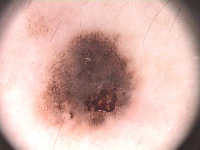</td><td>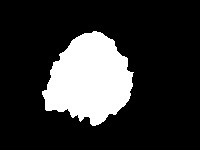</td></tr></table>

2. Разархивируем .rar файл.
3. Папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.

In [1]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

--2023-07-07 18:14:11--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8lqrloi0mxj2acu/PH2Dataset.rar [following]
--2023-07-07 18:14:12--  https://www.dropbox.com/s/raw/8lqrloi0mxj2acu/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucff03d7ca9ea1ebadbbb4cb1efe.dl.dropboxusercontent.com/cd/0/inline/B_Yd9FR1kKS7Qjf8j7ICwTJXaBe7ddwM0WE0zkUTedm67XX9CSEHxxdZM3XPvR0GAW89GIcb6hlPUXLxcrm131qSAXCaPVI66xPEEFJMKVKmfcxNrG1dnWXJ-S3l5VwKTYiwYe0XdmpIOVWC6G-qxl6dOozuwt5ktJ0KFm5-Lyh0ZA/file# [following]
--2023-07-07 18:14:13--  https://ucff03d7ca9ea1ebadbbb4cb1efe.dl.dropboxusercontent.com/cd/0/inline/B_Yd9FR1kKS7Qjf8j7ICwTJXaBe7ddwM0WE0zkUTedm67XX9CSEHxxdZM3XPvR0GAW89GIc

In [2]:
!ls

PH2Dataset.rar	sample_data


In [3]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Необходимые библиотеки:

In [78]:
from skimage.io import imread
import os
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.utils.data import DataLoader
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from matplotlib import cm
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)
from torchvision import models, transforms
import random
import copy
from torch.autograd import Variable

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [6]:
images = []
lesions = []

root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [7]:
print(f'Количество изображений - {len(images)}')

Количество изображений - 200


Изображения имеют разные размеры. Изменим их размер на $256\times256 $ пикселей с помощью [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [9]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [11]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Посмотрим на несколько изображений

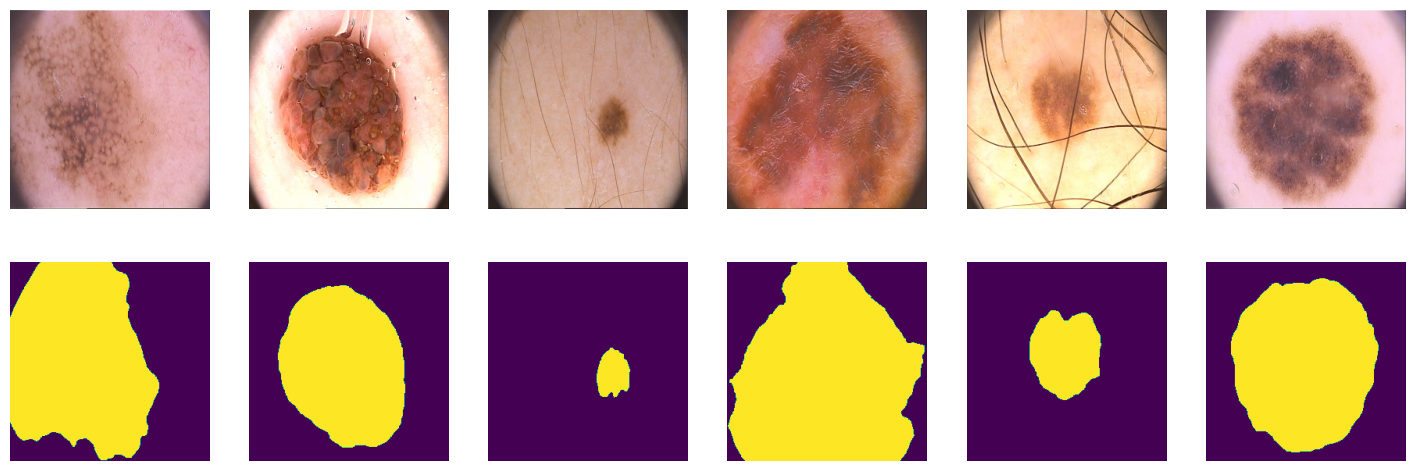

In [13]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [14]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [15]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [17]:
batch_size = 20
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:

-----------------------------------------------------------------------------------------

# SegNet

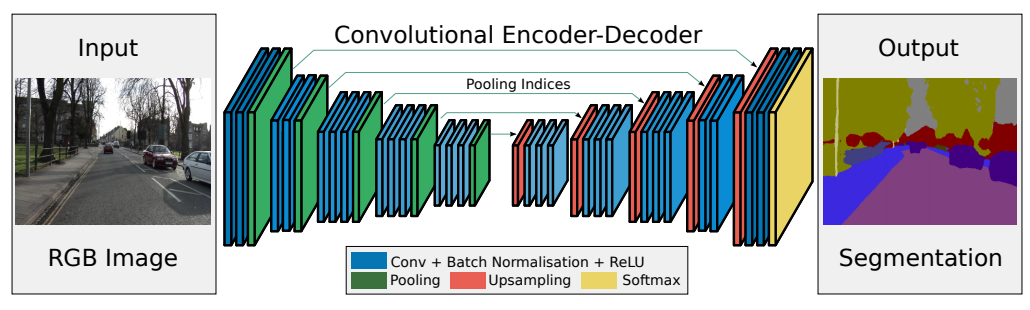

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [21]:
class SegNet(nn.Module):
    def __init__(self, inp_ch: int):
        super().__init__()
        """
        inp_ch - число фильтров в первом
        свёрточном слое
        """

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=inp_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch, out_channels=inp_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch),
            nn.ReLU()
        )

        self.pool0 = nn.MaxPool2d(kernel_size=2, return_indices=True)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=inp_ch*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*2),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*2, out_channels=inp_ch*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*2),
            nn.ReLU()
        )

        self.pool1 = nn.MaxPool2d(kernel_size=2, return_indices=True)  # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*2, out_channels=inp_ch*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*4),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*4, out_channels=inp_ch*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*4),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*4, out_channels=inp_ch*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*4),
            nn.ReLU()
        )

        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=True)  # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*4, out_channels=inp_ch*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*8, out_channels=inp_ch*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*8, out_channels=inp_ch*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*8),
            nn.ReLU()
        )

        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=True)  # 32 -> 16

        self.bottleneck_enc = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*8, out_channels=inp_ch*16, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*16),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*16, out_channels=inp_ch*16, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*16),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*16, out_channels=inp_ch*16, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*16),
            nn.ReLU()
        )

        self.bottleneck_pool = nn.MaxPool2d(kernel_size=2, return_indices=True)

        self.bottleneck_upsample = nn.MaxUnpool2d(kernel_size=2)

        self.bottleneck_dec = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*16, out_channels=inp_ch*16, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*16),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*16, out_channels=inp_ch*16, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*16),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*16, out_channels=inp_ch*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*8),
            nn.ReLU()
        )

        # Decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2)  # 16 -> 32

        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*8, out_channels=inp_ch*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*8, out_channels=inp_ch*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*8, out_channels=inp_ch*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*4),
            nn.ReLU()
        )

        self.upsample1 = nn.MaxUnpool2d(kernel_size=2)  # 32 -> 64

        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*4, out_channels=inp_ch*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*4),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*4, out_channels=inp_ch*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*4),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*4, out_channels=inp_ch*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*2),
            nn.ReLU()
        )

        self.upsample2 = nn.MaxUnpool2d(kernel_size=2)  # 64 -> 128

        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*2, out_channels=inp_ch*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*2),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*2, out_channels=inp_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch),
            nn.ReLU()
        )

        self.upsample3 = nn.MaxUnpool2d(kernel_size=2)  # 128 -> 256

        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=inp_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch, out_channels=1, kernel_size=3, padding=1),
        )


    def forward(self, x):
        # Encoder
        e0 = self.enc_conv0(x)
        e0, ind0 = self.pool0(e0)
        e1 = self.enc_conv1(e0)
        e1, ind1 = self.pool1(e1)
        e2 = self.enc_conv2(e1)
        e2, ind2 = self.pool2(e2)
        e3 = self.enc_conv3(e2)
        e3, ind3 = self.pool3(e3)

        # Bottleneck
        b = self.bottleneck_enc(e3)
        b, ind_b = self.bottleneck_pool(b)
        b = self.bottleneck_upsample(b, ind_b)
        b = self.bottleneck_dec(b)

        # Decoder
        d0 = self.upsample0(b, ind3)
        d0 = self.dec_conv0(d0)
        d1 = self.upsample1(d0, ind2)
        d1 = self.dec_conv1(d1)
        d2 = self.upsample2(d1, ind1)
        d2 = self.dec_conv2(d2)
        d3 = self.upsample3(d2, ind0)
        d3 = self.dec_conv3(d3) # No activation
        return d3

## Метрика

В данной архитектуре будет использоваться следующая метрика для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [22]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    iou_threshold = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10

    return iou_threshold

## Функция потерь

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [23]:
def bce_loss(y_pred, y_real):
    BCEloss = (torch.maximum(y_pred, torch.zeros_like(y_pred)) - y_pred*y_real + torch.log(1 + torch.exp(-torch.abs(y_pred)))).mean((1,2,3)).mean()
    return BCEloss

## Тренировка

Определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [25]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, is_scheduler=True, agm=True):
    """ Функция обучения и валидации

    Args:
        model - модель
        opt - оптимизатор
        loss_fn - функция потерь
        epochs - количество эпох
        data_tr - трэйн-сет
        data_val - валидационный сет
        is_scheduler - scheduler, default = True
        agm - augmentation, default = True

    Returns:
        history: {
               epoch: номер эпохи
               train_loss: значение функции потерь на трэйн-сете
               val_loss: значения функции потерь на валидационном сете
               train_score: значение метрики на трэйн-сете
               val_score: значение метрики на валидационном сете
              }
    """
    X_val, Y_val = next(iter(data_val))
    history = {"epochs": np.arange(epochs)+1, "train": {"score":[], "loss":[]}, "val": {"score":[], "loss":[]}}

    if is_scheduler:
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer=opt, gamma=0.95)

    # Set default parameters for saving model weights
    best_model_weights = model.state_dict()
    best_score_val = 0.0

    # Augmentations
    transforms_train = transforms.Compose([
        transforms.RandomHorizontalFlip(p=1),
        transforms.RandomAdjustSharpness(.9, p=0.5),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.7, contrast=0.7, saturation=0.7)], p=0.5),
        transforms.RandomApply([transforms.Grayscale(3),], p=0.5)
    ])

    transforms_test = transforms.Compose([
        transforms.RandomHorizontalFlip(p=1)
    ])

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        avg_loss = 0
        avg_score = 0
        avg_loss_val = 0
        avg_score_val = 0

        model.train()  # Train mode
        for X_batch, Y_batch in data_tr:
            # Data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            if agm:
                if random.random() > 0.6:  # Bероятность применения аугментций
                    X_batch = transforms_train(X_batch)
                    Y_batch = transforms_test(Y_batch)
            # Set parameter gradients to zero
            opt.zero_grad()
            # Forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch) # Forward-pass
            loss.backward()  # Backward-pass
            opt.step()  # Update weights
            score = iou_pytorch(torch.sigmoid(Y_pred) > 0.5, Y_batch).mean().item() # Make score

            # Calculate loss to show the user
            avg_loss += loss / len(data_tr)
            avg_score += score / len(data_tr)

        toc = time()
        print('loss: %f' % avg_loss)
        if is_scheduler:
            scheduler.step()

        # Show intermediate results
        model.eval()  # Testing mode
        Y_hat = model(X_val.to(device)).detach().to('cpu') # Detach and put into cpu

        # Visualize tools
        clear_output(wait=True)

        # Validation
        with torch.no_grad():
            for X_val_batch, Y_val_batch in data_val:
                X_val_batch = X_val_batch.to(device)
                Y_val_batch = Y_val_batch.to(device)
                Y_pred_val = model(X_val_batch)
                loss_val = loss_fn(Y_pred_val, Y_val_batch)
                score_val = iou_pytorch(torch.sigmoid(Y_pred_val) > 0.5, Y_val_batch)
                avg_loss_val += loss / len(data_val)
                avg_score_val += score_val.mean() / len(data_val)

        # Save best model weights
        if avg_score_val.cpu().item() > best_score_val:
            best_score_val = avg_score_val
            best_model_weights = copy.deepcopy(model.state_dict())

        # Adding to history
        history["train"]["score"].append(avg_score)
        history["val"]["score"].append(avg_score_val.item())
        history["train"]["loss"].append(avg_loss.item())
        history["val"]["loss"].append(avg_loss_val.item())

        # Visualisations
        fig, ax = plt.subplots(3, 6, figsize=(12, 10))
        for k in range(6):
            ax[0, k].imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            ax[0, k].set_title("Real")
            ax[0, k].axis('off')
            ax[1, k].imshow(torch.sigmoid(Y_hat[k, 0]) > 0.5, cmap='gray')
            ax[1, k].set_title("Output")
            ax[1, k].axis('off')
            ax[2, k].imshow(Y_val[k, 0], cmap='gray')
            ax[2, k].set_title("Ground Truth")
            ax[2, k].axis('off')
        plt.suptitle('%d / %d - train_loss: %f, val_loss: %f, train_score: %f, val_score: %f' % (epoch+1, epochs, avg_loss, avg_loss_val, avg_score, avg_score_val))
        plt.tight_layout()
        plt.show()

    # Delete cache
    X_batch.to('cpu')
    del X_batch
    Y_batch.to('cpu')
    del Y_batch
    X_val_batch.to('cpu')
    del X_val_batch
    Y_val_batch.to('cpu')
    del Y_val_batch

    # load best model weights
    model.load_state_dict(best_model_weights)
    torch.cuda.empty_cache()

    return history

## Инференс

In [31]:
def graph(history, model_name, loss_name):
    '''function to visualize score and loss plots throw epochs'''
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    x = history["epochs"]
    loss_train = history["train"]["loss"]
    loss_val = history["val"]["loss"]
    score_train = history["train"]["score"]
    score_val = history["val"]["score"]

    ax[0].plot(x, loss_train, label="train", color="blue")
    ax[0].plot(x, loss_val, label="val", color="orange")
    ax[0].legend(fontsize=14)
    ax[0].grid(linestyle="--")
    ax[0].tick_params(labelsize=14)
    ax[0].set_xlabel("epoch", fontsize=14)
    ax[0].set_ylabel("loss", fontsize=14)
    ax[0].set_title("Loss vs epoch", fontsize=16)
    ax[0].set_xlim(left=0, right=x.max())
    ax[0].set_ylim(bottom=0)
    ax[1].plot(x, score_train, label="train", color="blue")
    ax[1].plot(x, score_val, label="val", color="orange")
    ax[1].legend(fontsize=14)
    ax[1].grid(linestyle="--")
    ax[1].tick_params(labelsize=14)
    ax[1].set_xlabel("epoch", fontsize=14)
    ax[1].set_ylabel("score", fontsize=14)
    ax[1].set_title("Score vs epoch", fontsize=16)
    ax[1].set_xlim(left=0, right=x.max())
    ax[1].set_ylim(bottom=0)
    plt.suptitle(f"Model = {model_name}, loss = {loss_name}", fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
def score_model(model, metric, data):
    model.eval()  # Testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = torch.sigmoid(model(X_batch.to(device))) > 0.5
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение


### SegNet с BCE loss

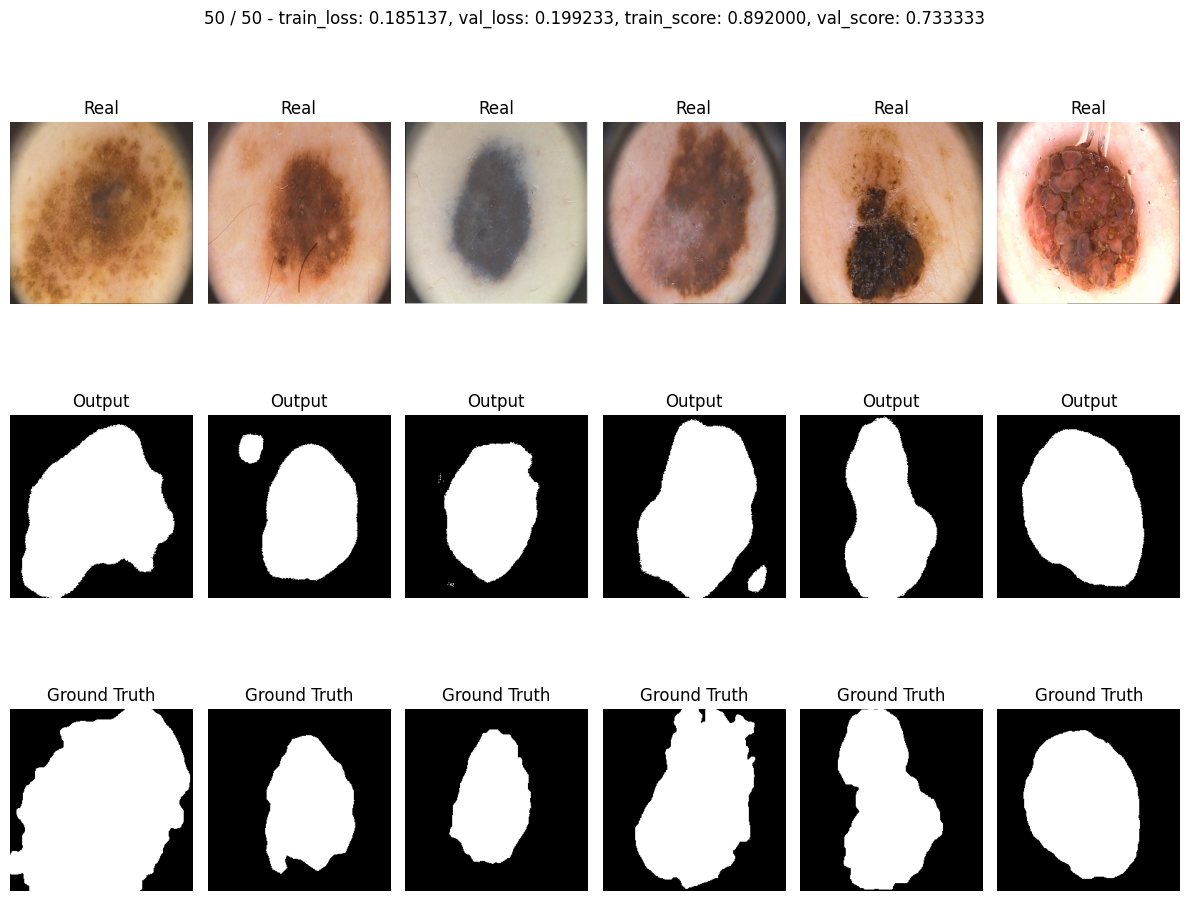

In [30]:
model_segnet_bce = SegNet(32).to(device)

max_ep = 50
opt = optim.Adam(model_segnet_bce.parameters(), lr=1e-4, amsgrad=True)
segnet_bce = train(model_segnet_bce, opt, bce_loss, max_ep, data_tr, data_val, agm=True)

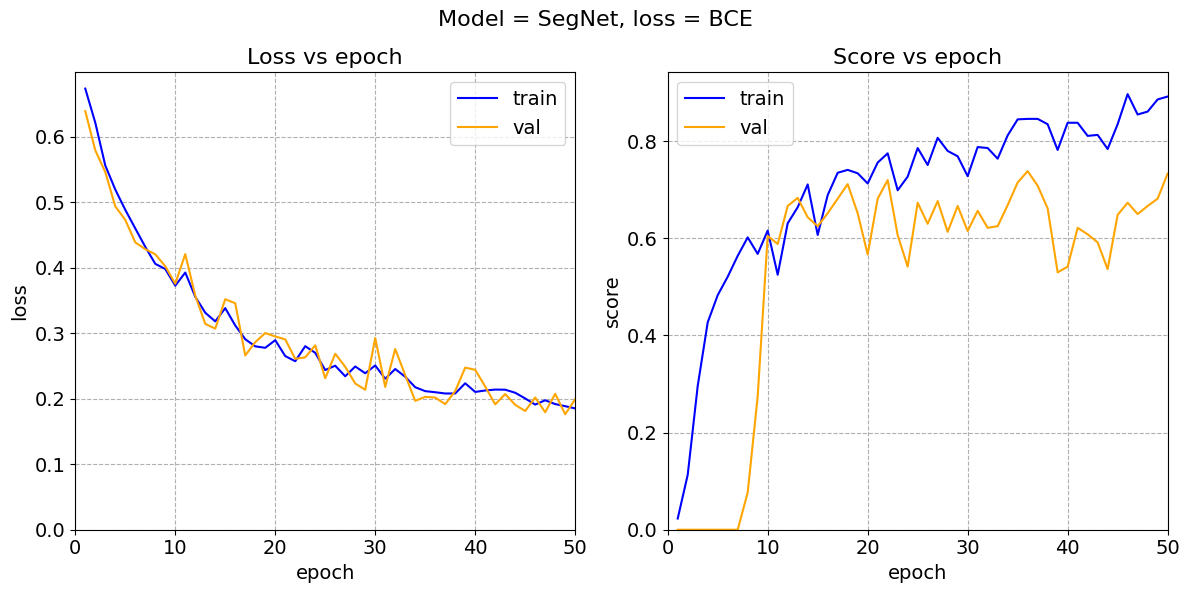

In [32]:
graph(segnet_bce, "SegNet", "BCE")

In [33]:
score_model(model_segnet_bce, iou_pytorch, data_val)

0.7050000230471293

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь

### SegNet с Dice loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$


In [34]:
def dice_loss(y_pred, y_real):
    smooth = 1.
    y_pred = torch.sigmoid(y_pred)
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
    num = (2 * (y_pred * y_real).sum() + smooth)
    den = (y_pred.sum() + y_real.sum() + smooth)
    res = 1 - (num/den).mean()  # mean per batch
    return res

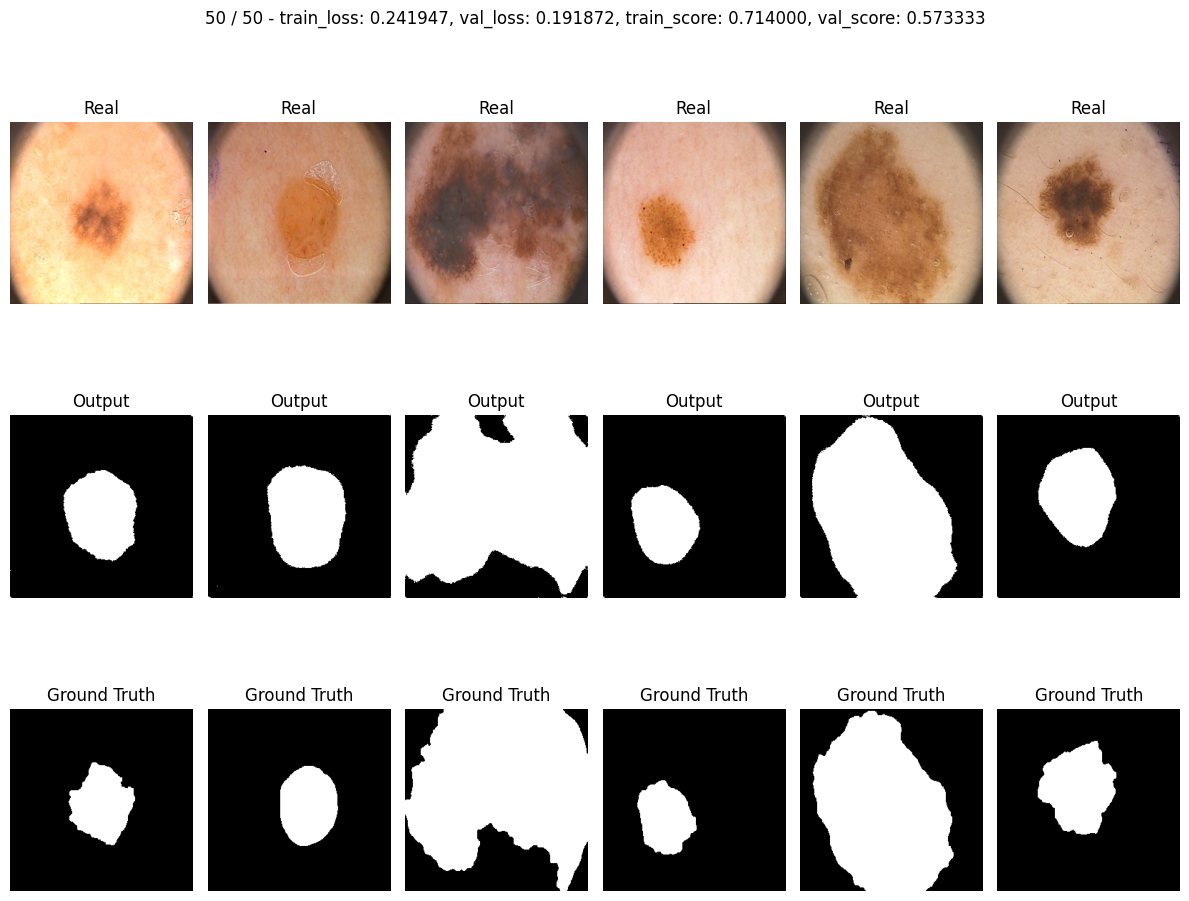

In [35]:
model_segnet_dice = SegNet(32).to(device)

max_epochs = 50
opt = optim.Adam(model_segnet_dice.parameters(), lr=1e-4, amsgrad=True)
segnet_dice = train(model_segnet_dice, opt, dice_loss, max_epochs, data_tr, data_val, agm=True)

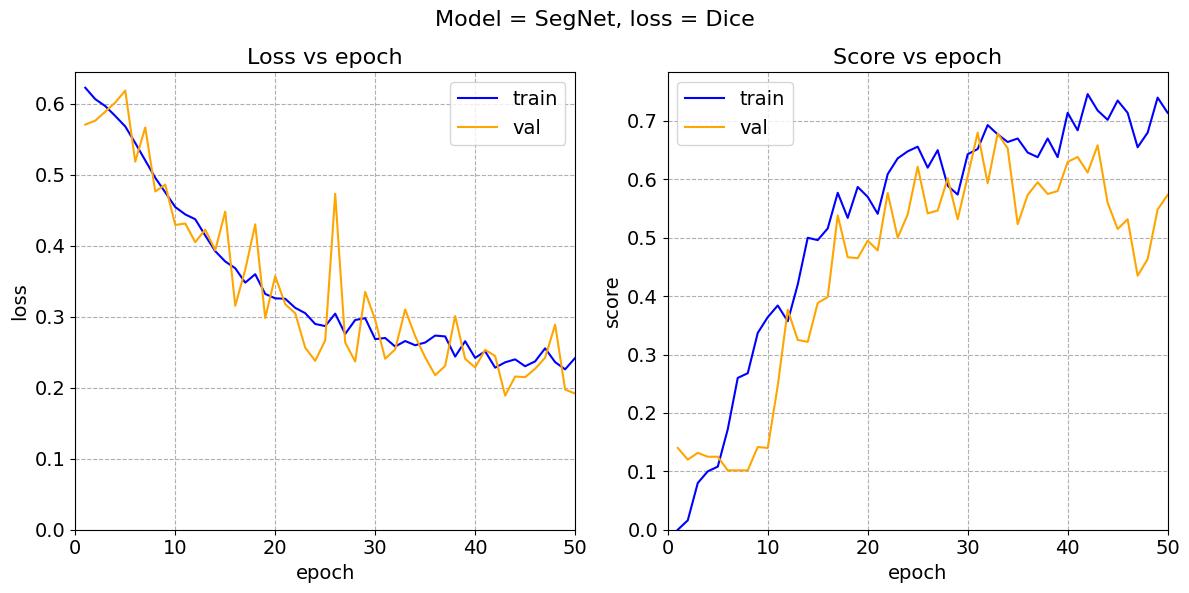

In [36]:
graph(segnet_dice, "SegNet", "Dice")

In [37]:
score_model(model_segnet_dice, iou_pytorch, data_val)

0.6783333222071329

### SegNet с Focal loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [38]:
def focal_loss(y_pred, y_real, eps=-1, gamma=2):
    p = torch.sigmoid(y_pred)
    ce_loss = torch.maximum(y_pred, torch.zeros_like(y_pred)) - y_pred*y_real + torch.log(1 + torch.exp(-torch.abs(y_pred)))
    p_t = p*y_real + (1 - p)*(1 - y_real)
    loss = ce_loss*((1 - p_t)**gamma)
    if eps >= 0:
        alpha_t = eps*y_real + (1 - eps)*(1 - y_real)
        loss = alpha_t*loss
    loss = loss.mean((1,2,3)).mean()  # mean per batch
    return loss

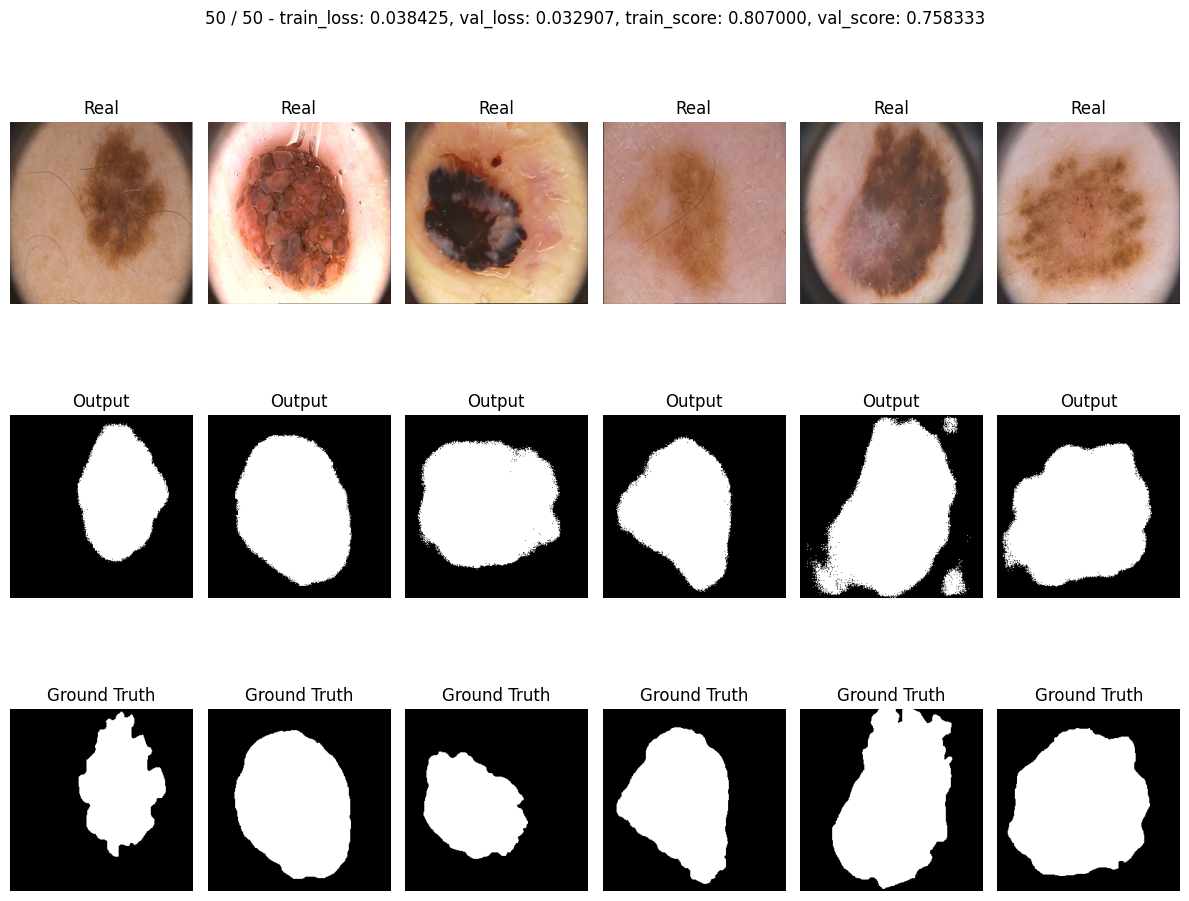

In [39]:
model_segnet_focal = SegNet(32).to(device)

max_epochs = 50
opt = optim.Adam(model_segnet_focal.parameters(), lr=1e-4, amsgrad=True)
segnet_focal = train(model_segnet_focal, opt, focal_loss, max_epochs, data_tr, data_val, agm=True)

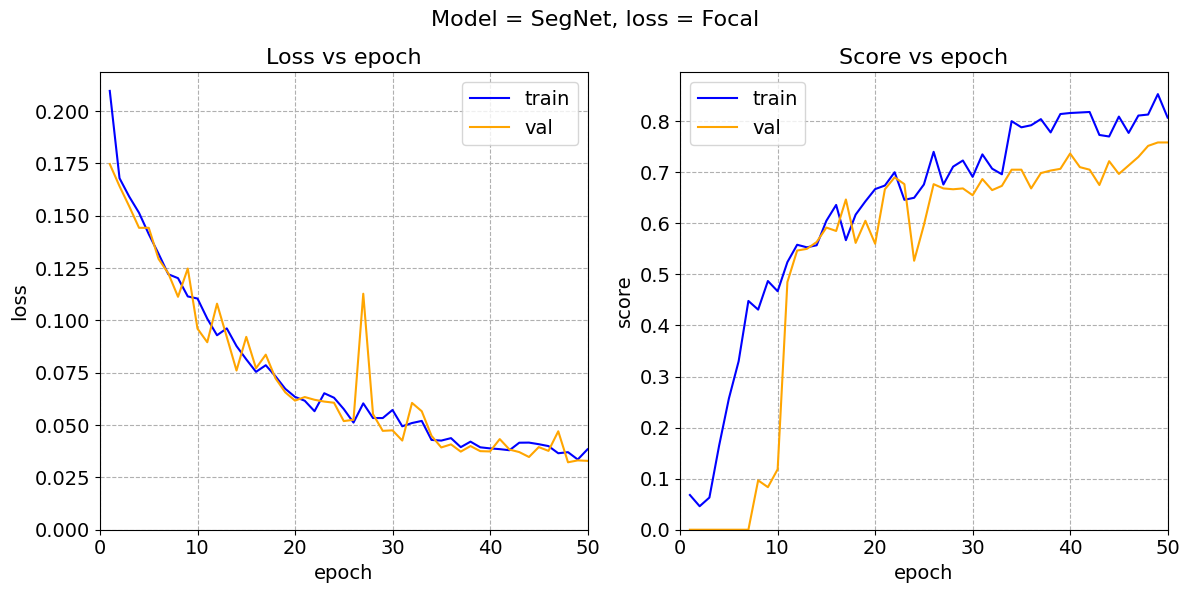

In [42]:
graph(segnet_focal, "SegNet", "Focal")

In [41]:
score_model(model_segnet_focal, iou_pytorch, data_val)

0.7633333603541056

### SegNet с Lovasz Softmax loss

In [43]:
# take from https://github.com/bermanmaxim/LovaszSoftmax/blob/master/pytorch/lovasz_losses.py

# Градиент вектора ошибок
def lovasz_grad(gt_sorted):
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard

def lovasz_loss(logits, labels):
    labels = labels.view(-1)
    logits = logits.view(-1)

    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.

    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    return loss

In [44]:
model_segnet_lovasz = SegNet(32).to(device)

max_epochs = 50
opt = optim.Adam(model_segnet_lovasz.parameters(), lr=1e-4, amsgrad=True)
segnet_lovasz = train(model_segnet_lovasz, opt, lovasz_loss, max_epochs, data_tr, data_val, agm=True)

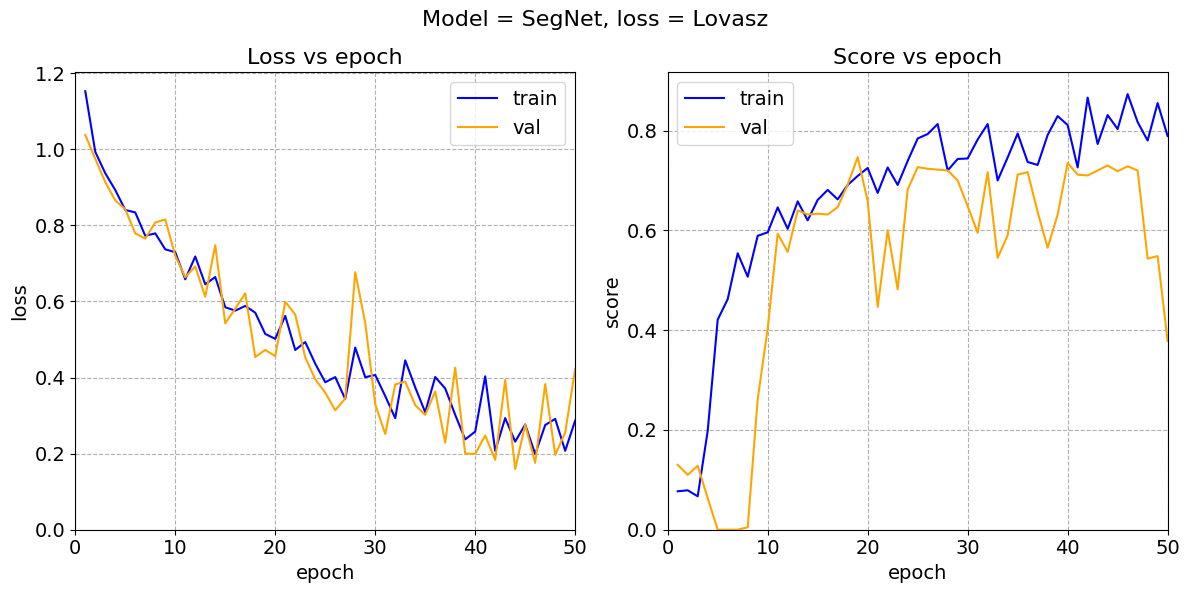

In [45]:
graph(segnet_lovasz, "SegNet", "Lovasz")

In [46]:
score_model(model_segnet_lovasz, iou_pytorch, data_val)

0.7300000190734863

-----------------------------------------------------------------------------------------

# U-Net

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

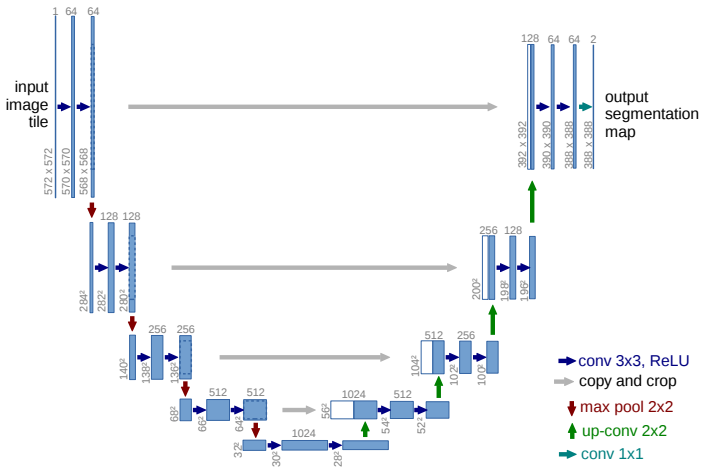

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [47]:
class UNet(nn.Module):
    def __init__(self, inp_ch:int):
        super().__init__()
        """
        inp_ch - число фильтров в первом
        свёрточном слое
        """

        # Encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=inp_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch, out_channels=inp_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch),
            nn.ReLU()
        )

        self.pool0 = nn.MaxPool2d(kernel_size=2, return_indices=False)

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=inp_ch*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*2),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*2, out_channels=inp_ch*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*2),
            nn.ReLU()
        )

        self.pool1 = nn.MaxPool2d(kernel_size=2, return_indices=False)

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*2, out_channels=inp_ch*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*4),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*4, out_channels=inp_ch*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*4),
            nn.ReLU()
        )

        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=False)

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*4, out_channels=inp_ch*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*8, out_channels=inp_ch*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*8),
            nn.ReLU()
        )

        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=False)

        self.bottleneck_enc = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*8, out_channels=inp_ch*16, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*16),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*16, out_channels=inp_ch*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*8),
            nn.ReLU()
        )

        # Decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2)

        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*16, out_channels=inp_ch*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*8, out_channels=inp_ch*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*4),
            nn.ReLU()
        )

        self.upsample1 = nn.Upsample(scale_factor=2)

        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*8, out_channels=inp_ch*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*4),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*4, out_channels=inp_ch*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*2),
            nn.ReLU()
        )

        self.upsample2 = nn.Upsample(scale_factor=2)

        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*4, out_channels=inp_ch*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*2),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*2, out_channels=inp_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch),
            nn.ReLU()
        )

        self.upsample3 = nn.Upsample(scale_factor=2)

        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*2, out_channels=inp_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch, out_channels=inp_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch, out_channels=1, kernel_size=1)
        )



    def forward(self, x):
        # Encoder
        e0 = self.enc_conv0(x)
        e1 = self.pool0(e0)
        e2 = self.enc_conv1(e1)
        e3 = self.pool1(e2)
        e4 = self.enc_conv2(e3)
        e5 = self.pool2(e4)
        e6 = self.enc_conv3(e5)
        e7 = self.pool3(e6)

        # Bottleneck
        b = self.bottleneck_enc(e7)

        # Decoder
        d0 = self.upsample0(b)
        d0 = self.dec_conv0(torch.cat((d0,e6), dim=1))
        d1 = self.upsample1(d0)
        d1 = self.dec_conv1(torch.cat((d1,e4), dim=1))
        d2 = self.upsample2(d1)
        d2 = self.dec_conv2(torch.cat((d2,e2), dim=1))
        d3 = self.upsample3(d2)
        d3 = self.dec_conv3(torch.cat((d3,e0), dim=1))
        return d3

### U-Net с BCE loss

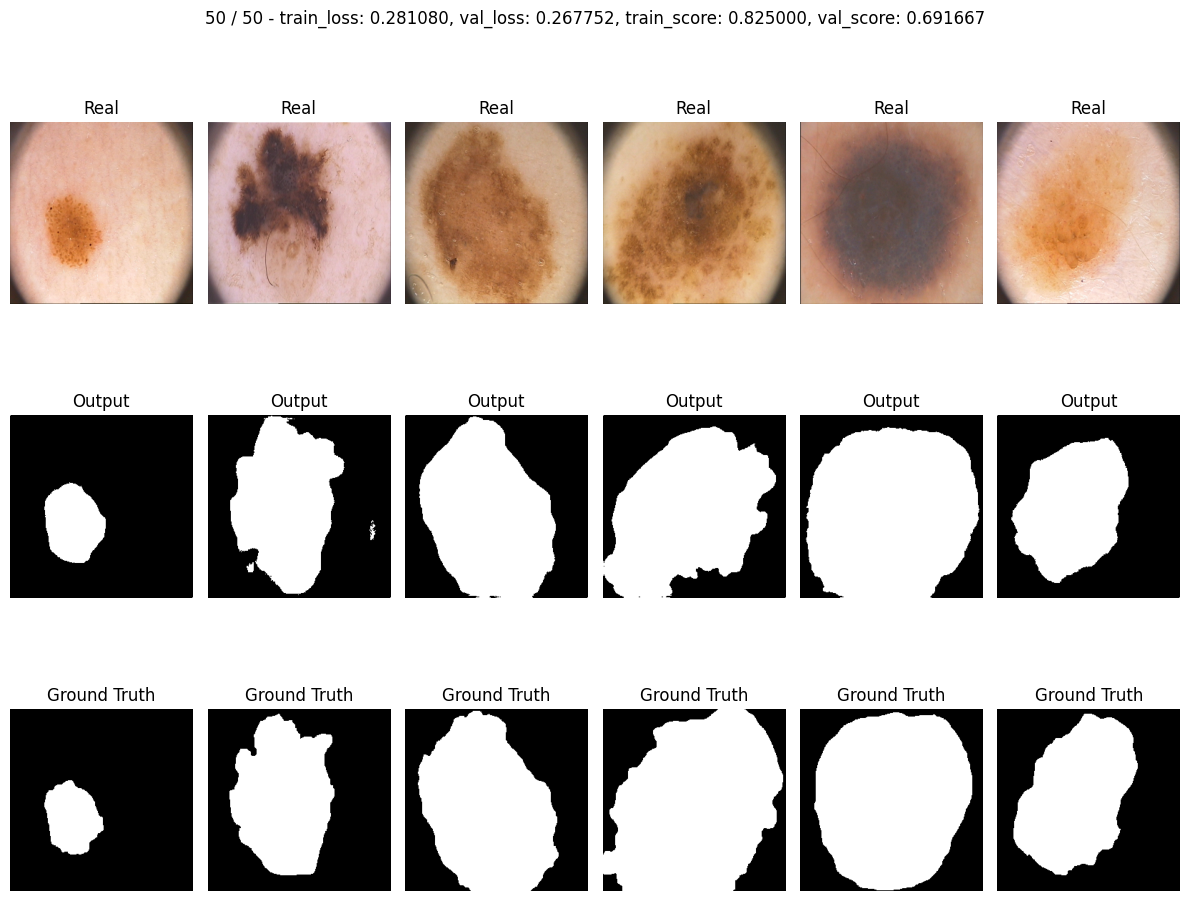

In [48]:
model_unet_bce = UNet(32).to(device)

max_epochs = 50
opt = optim.Adam(model_unet_bce.parameters(), lr=1e-4, amsgrad=True)
unet_bce = train(model_unet_bce, opt, bce_loss, max_epochs, data_tr, data_val, agm=True)

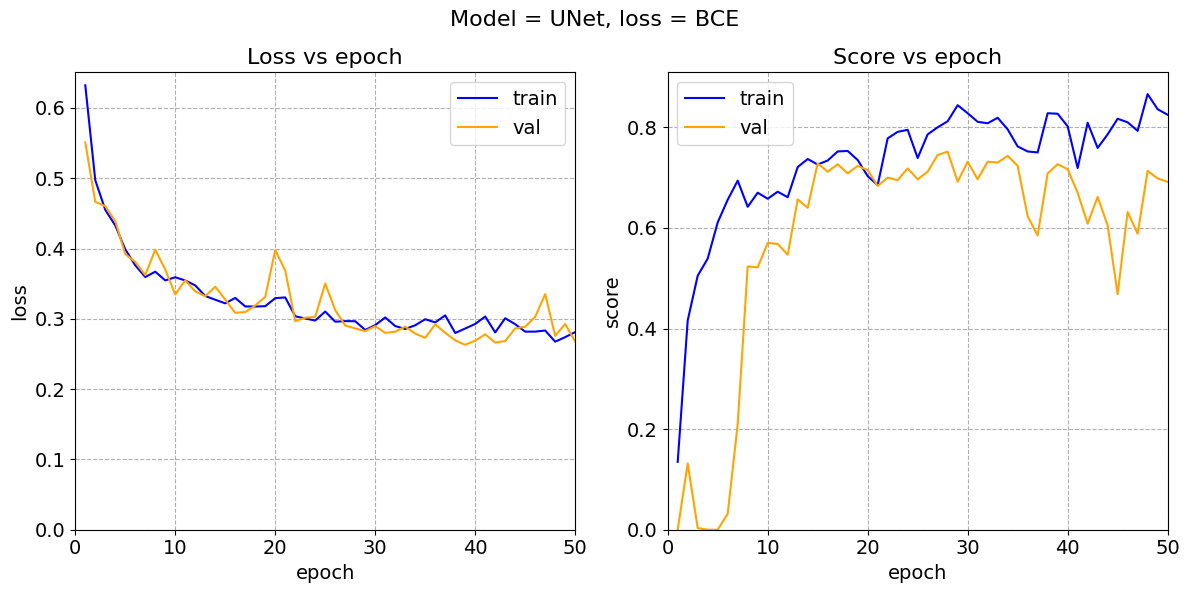

In [49]:
graph(unet_bce, "UNet", "BCE")

In [50]:
score_model(model_unet_bce, iou_pytorch, data_val)

0.75

### U-Net с Dice loss

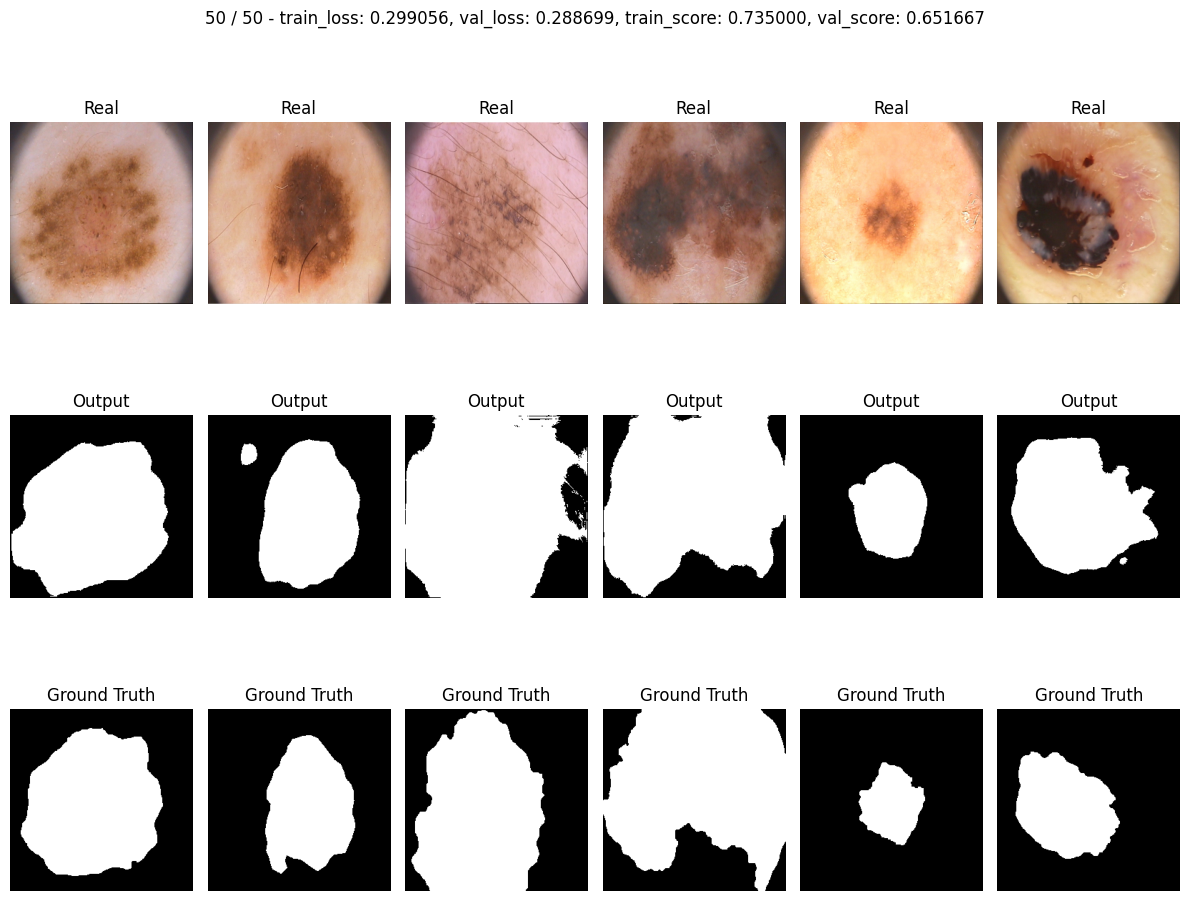

In [51]:
model_unet_dice = UNet(32).to(device)

max_epochs = 50
opt = optim.Adam(model_unet_dice.parameters(), lr=1e-4, amsgrad=True)
unet_dice = train(model_unet_dice, opt, dice_loss, max_epochs, data_tr, data_val, agm=True)

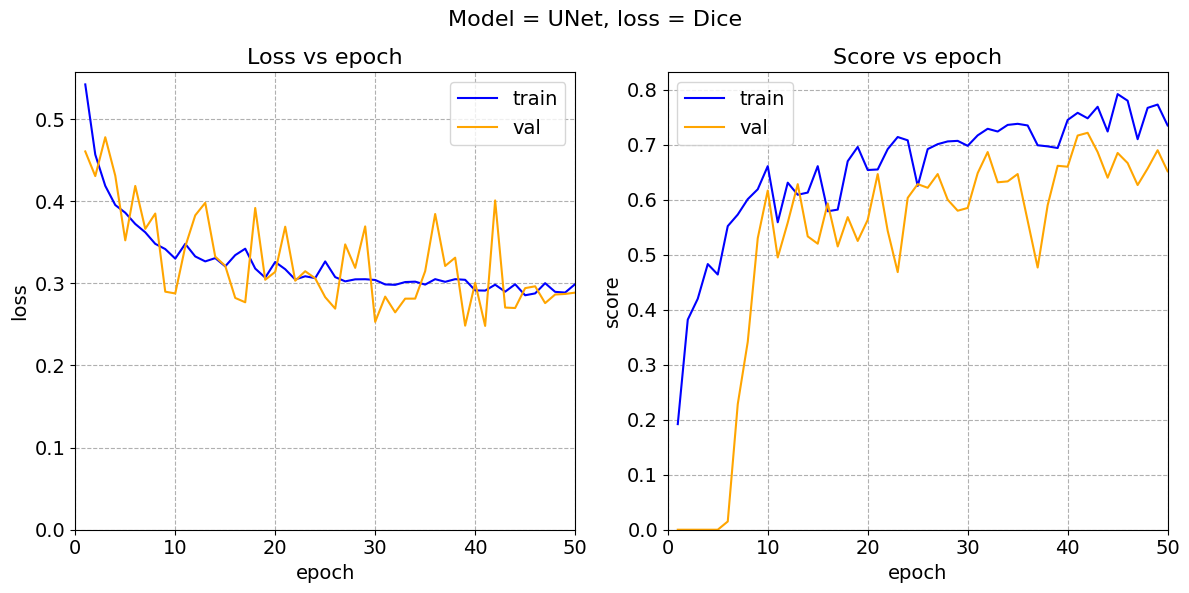

In [52]:
graph(unet_dice, "UNet", "Dice")

In [53]:
score_model(model_unet_dice, iou_pytorch, data_val)

0.7116666833559672

### U-Net с Focal loss

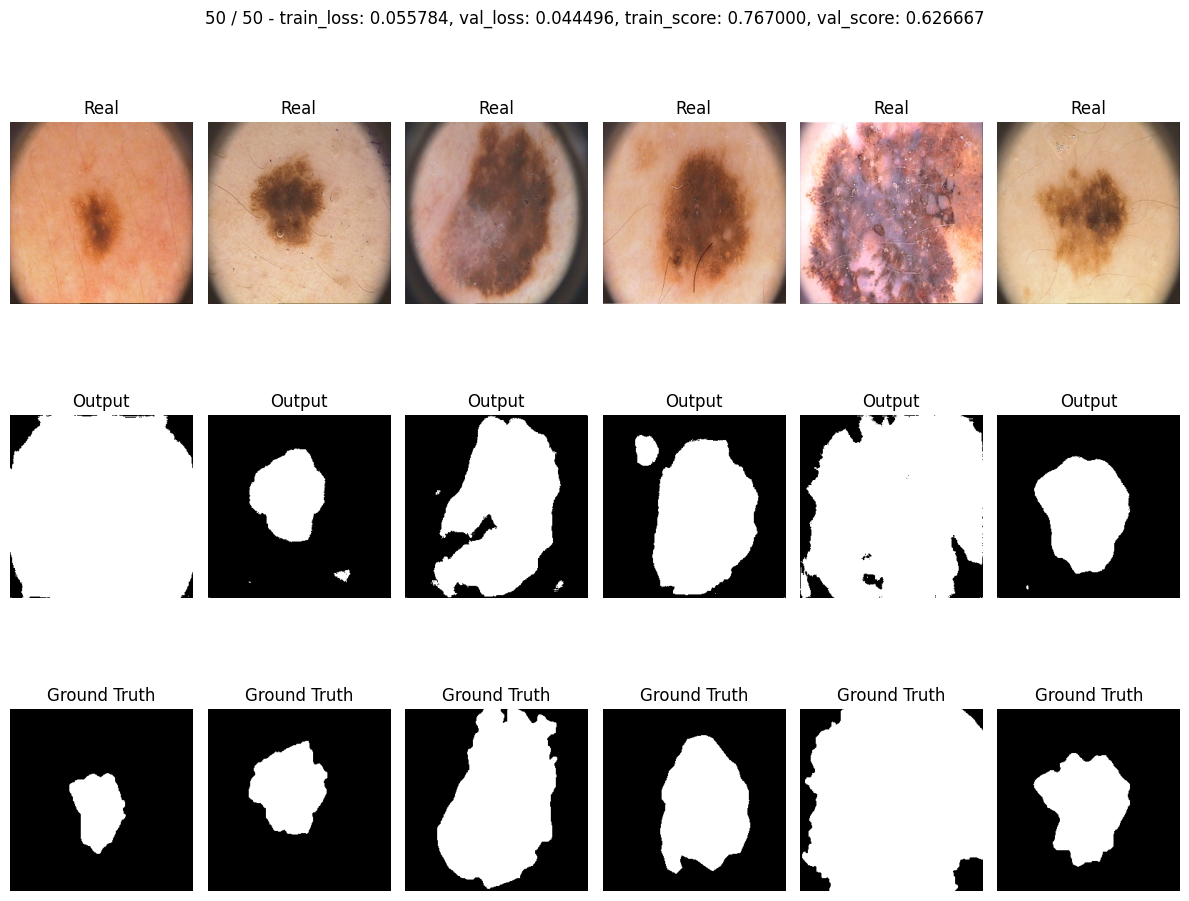

In [54]:
model_unet_focal = UNet(32).to(device)

max_epochs = 50
opt = optim.Adam(model_unet_focal.parameters(), lr=1e-4, amsgrad=True)
unet_focal = train(model_unet_focal, opt, focal_loss, max_epochs, data_tr, data_val, agm=True)

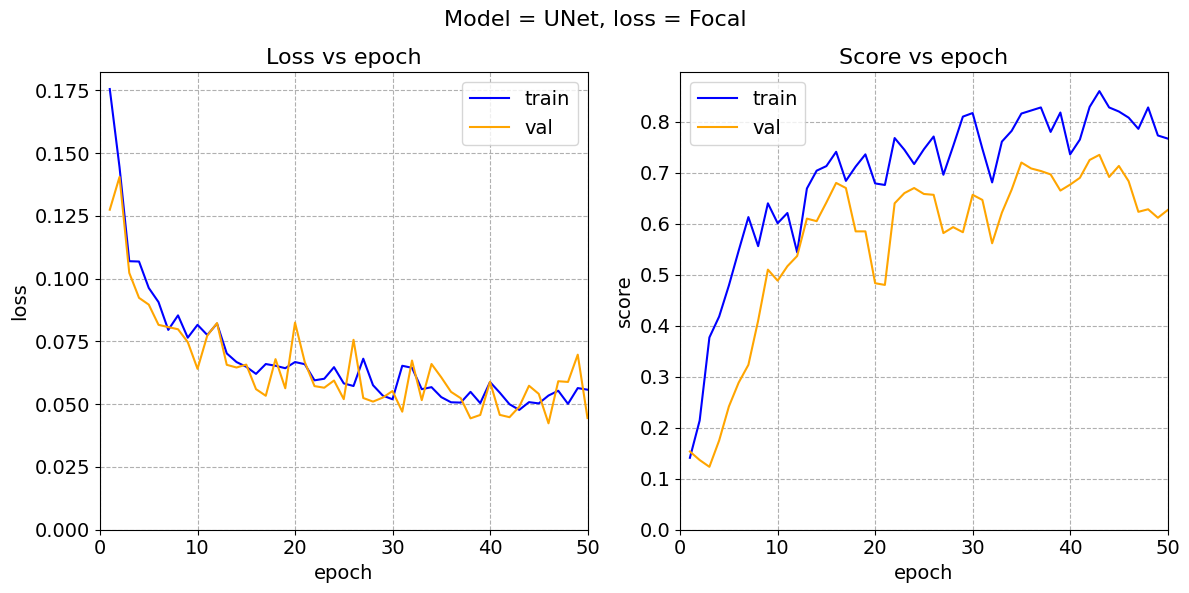

In [55]:
graph(unet_focal, "UNet", "Focal")

In [56]:
score_model(model_unet_focal, iou_pytorch, data_val)

0.7250000238418579

### U-Net с Lovasz Softmax loss

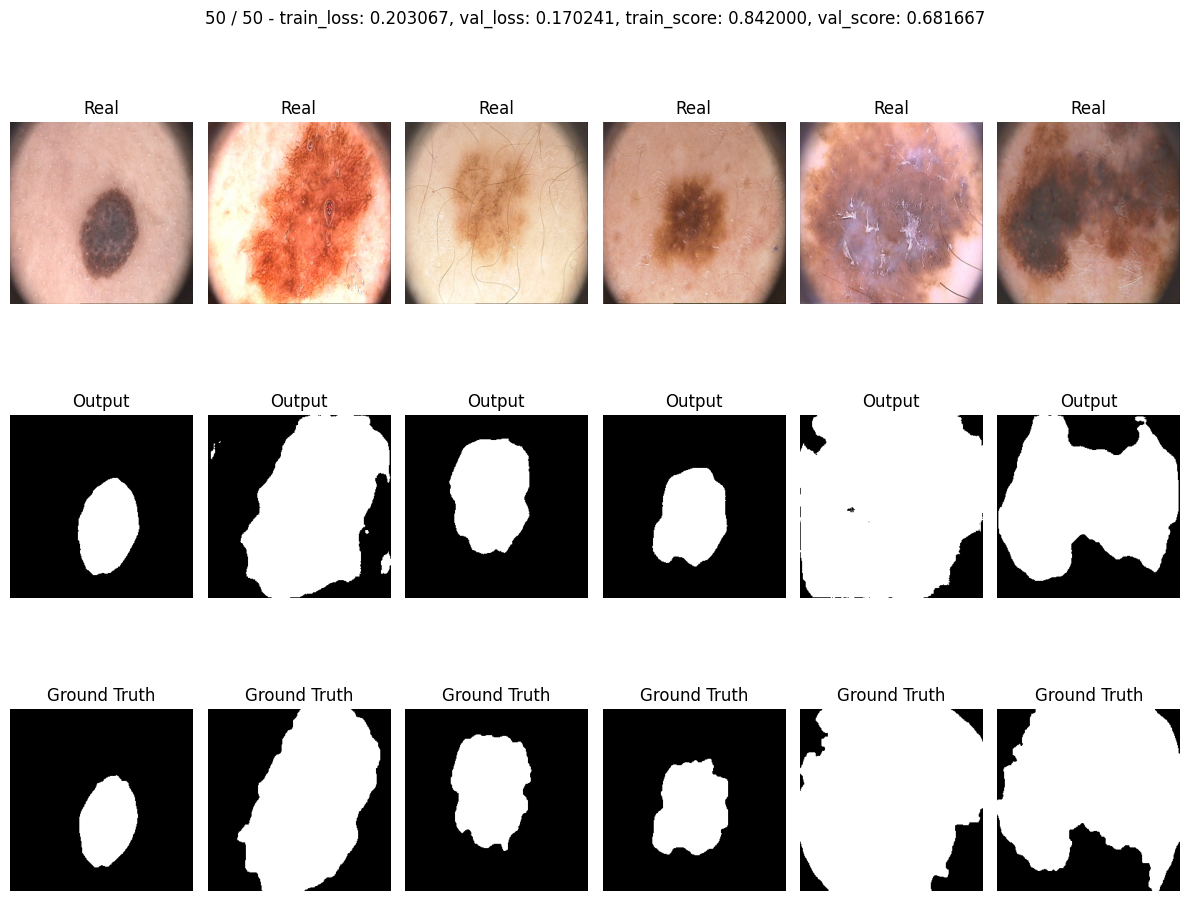

In [57]:
model_unet_lovasz = UNet(32).to(device)

max_epochs = 50
opt = optim.Adam(model_unet_lovasz.parameters(), lr=1e-4, amsgrad=True)
unet_lovasz = train(model_unet_lovasz, opt, lovasz_loss, max_epochs, data_tr, data_val, agm=True)

In [58]:
graph(unet_lovasz, "UNet", "Lovasz")

In [59]:
score_model(model_unet_lovasz, iou_pytorch, data_val)

0.7600000301996866

# U-Net2

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Заменим max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.

In [60]:
class UNet2(nn.Module):
    def __init__(self, inp_ch:int):
        super().__init__()
        """
        inp_ch - число фильтров в первом
        свёрточном слое
        """

        # Encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=inp_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch, out_channels=inp_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch),
            nn.ReLU()
        )

        self.pool0 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=inp_ch, kernel_size=2, stride=2),
            nn.BatchNorm2d(inp_ch),
            nn.ReLU()
        )

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=inp_ch*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*2),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*2, out_channels=inp_ch*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*2),
            nn.ReLU()
        )

        self.pool1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*2, out_channels=inp_ch*2, kernel_size=2, stride=2),
            nn.BatchNorm2d(inp_ch*2),
            nn.ReLU()
        )

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*2, out_channels=inp_ch*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*4),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*4, out_channels=inp_ch*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*4),
            nn.ReLU()
        )

        self.pool2 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*4, out_channels=inp_ch*4, kernel_size=2, stride=2),
            nn.BatchNorm2d(inp_ch*4),
            nn.ReLU()
        )

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*4, out_channels=inp_ch*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*8, out_channels=inp_ch*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*8),
            nn.ReLU()
        )

        self.pool3 = nn.Sequential(
        nn.Conv2d(in_channels=inp_ch*8, out_channels=inp_ch*8, kernel_size=2, stride=2),
        nn.BatchNorm2d(inp_ch*8),
        nn.ReLU()
        )

        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*8, out_channels=inp_ch*16, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*16),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*16, out_channels=inp_ch*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*8),
            nn.ReLU()
        )

        # Decoder (upsampling)
        self.upsample0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=inp_ch*8, out_channels=inp_ch*8, kernel_size=2, stride=2),
            nn.BatchNorm2d(inp_ch*8),
            nn.ReLU()
        )

        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*16, out_channels=inp_ch*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*8, out_channels=inp_ch*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*4),
            nn.ReLU()
        )

        self.upsample1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=inp_ch*4, out_channels=inp_ch*4, kernel_size=2, stride=2),
            nn.BatchNorm2d(inp_ch*4),
            nn.ReLU()
        )

        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*8, out_channels=inp_ch*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*4),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*4, out_channels=inp_ch*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*2),
            nn.ReLU()
        )

        self.upsample2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=inp_ch*2, out_channels=inp_ch*2, kernel_size=2, stride=2),
            nn.BatchNorm2d(inp_ch*2),
            nn.ReLU()
        )

        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*4, out_channels=inp_ch*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch*2),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*2, out_channels=inp_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch),
            nn.ReLU()
        )

        self.upsample3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=inp_ch, out_channels=inp_ch, kernel_size=2, stride=2),
            nn.BatchNorm2d(inp_ch),
            nn.ReLU()
        )

        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*2, out_channels=inp_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch, out_channels=inp_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch, out_channels=1, kernel_size=1)
        )



    def forward(self, x):
        # Encoder
        e0 = self.enc_conv0(x)
        e1 = self.pool0(e0)
        e2 = self.enc_conv1(e1)
        e3 = self.pool1(e2)
        e4 = self.enc_conv2(e3)
        e5 = self.pool2(e4)
        e6 = self.enc_conv3(e5)
        e7 = self.pool3(e6)

        # Bottleneck
        b = self.bottleneck(e7)

        # Decoder
        d0 = self.upsample0(b)
        d0 = self.dec_conv0(torch.cat((d0,e6), dim=1))
        d1 = self.upsample1(d0)
        d1 = self.dec_conv1(torch.cat((d1,e4), dim=1))
        d2 = self.upsample2(d1)
        d2 = self.dec_conv2(torch.cat((d2,e2), dim=1))
        d3 = self.upsample3(d2)
        d3 = self.dec_conv3(torch.cat((d3,e0), dim=1)) # No activation
        return d3

### U-Net2 с BCE loss

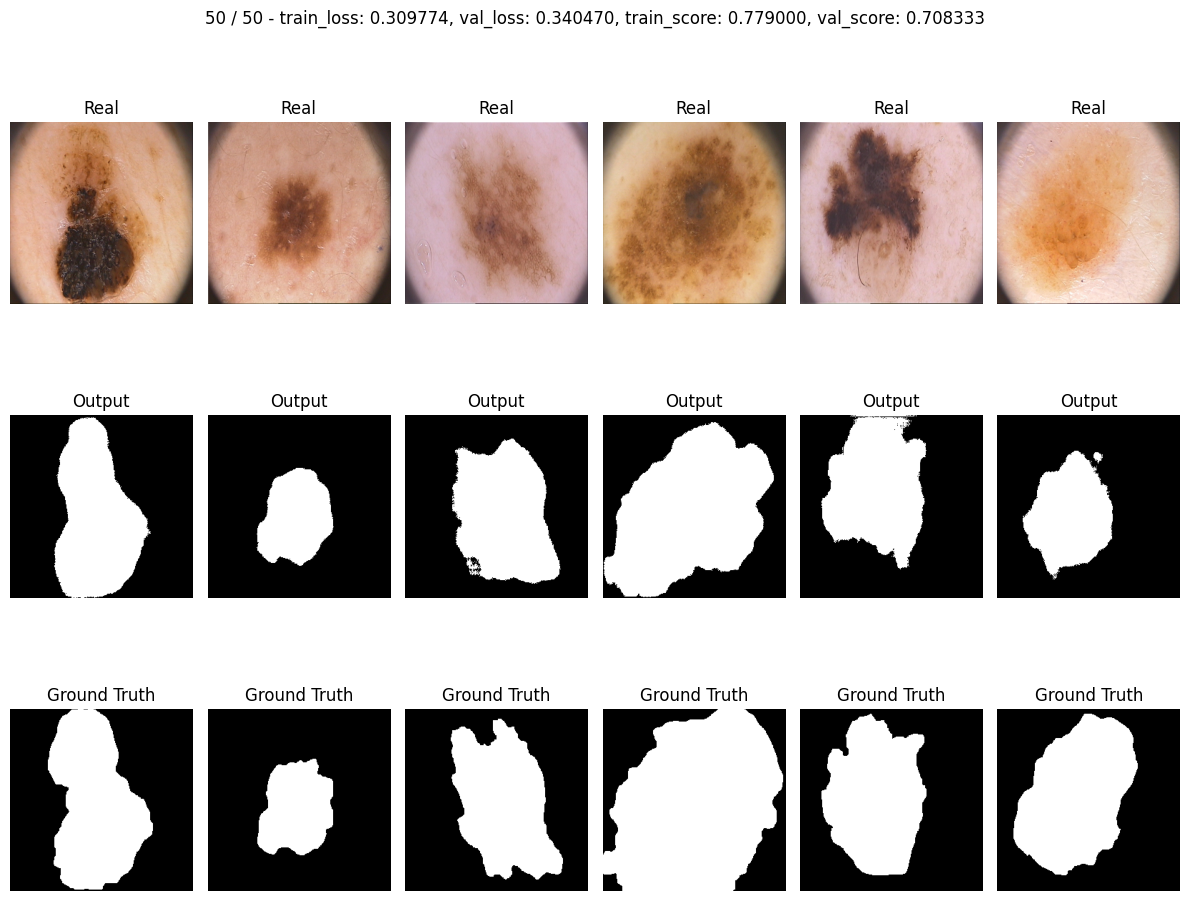

In [61]:
model_unet2_bce = UNet2(32).to(device)

max_epochs = 50
opt = optim.Adam(model_unet2_bce.parameters(), lr=1e-4, amsgrad=True)
unet2_bce = train(model_unet2_bce, opt, bce_loss, max_epochs, data_tr, data_val, agm=True)

In [62]:
graph(unet2_bce, "UNet2", "BCE")

In [69]:
score_model(model_unet2_bce, iou_pytorch, data_val)

0.768333355585734

### U-Net2 с Dice loss

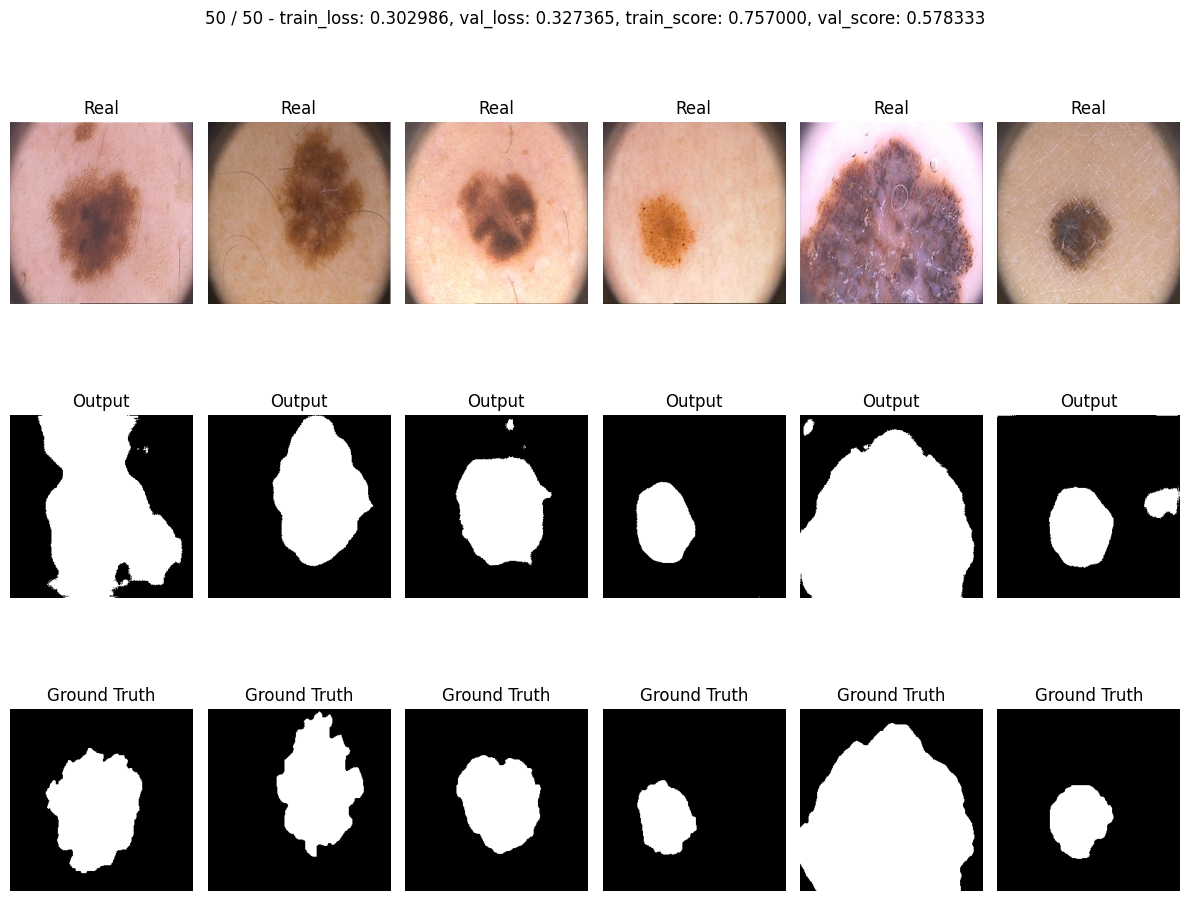

In [63]:
model_unet2_dice = UNet2(32).to(device)

max_epochs = 50
opt = optim.Adam(model_unet2_dice.parameters(), lr=1e-4, amsgrad=True)
unet2_dice = train(model_unet2_dice, opt, dice_loss, max_epochs, data_tr, data_val, agm=True)

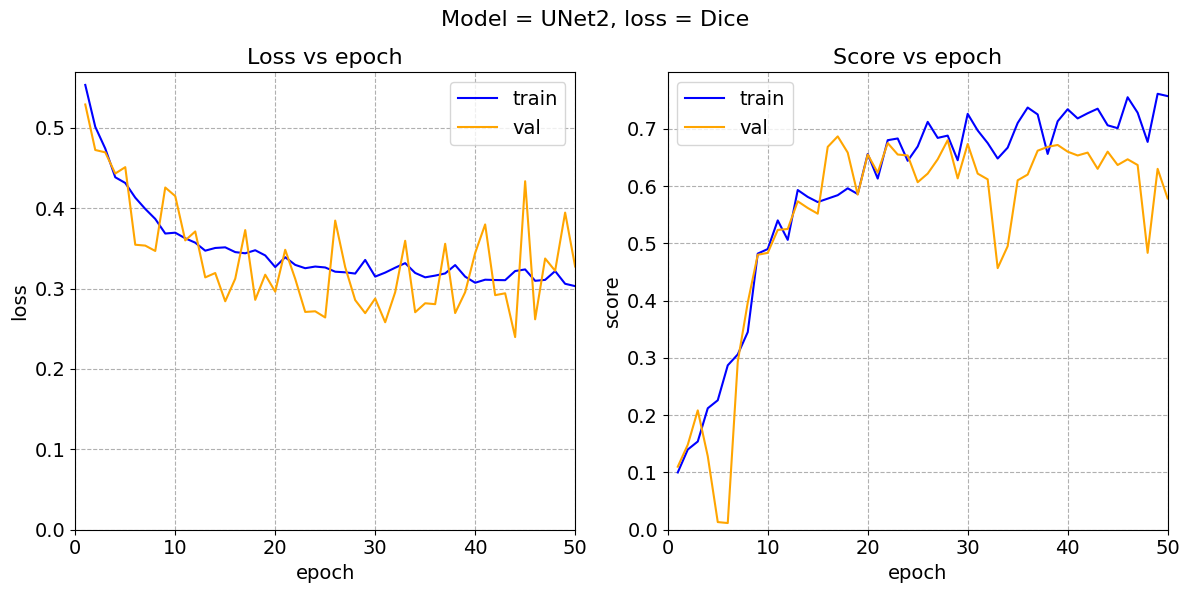

In [64]:
graph(unet2_dice, "UNet2", "Dice")

In [68]:
score_model(model_unet2_dice, iou_pytorch, data_val)

0.6966666579246521

### U-Net2 с Focal loss

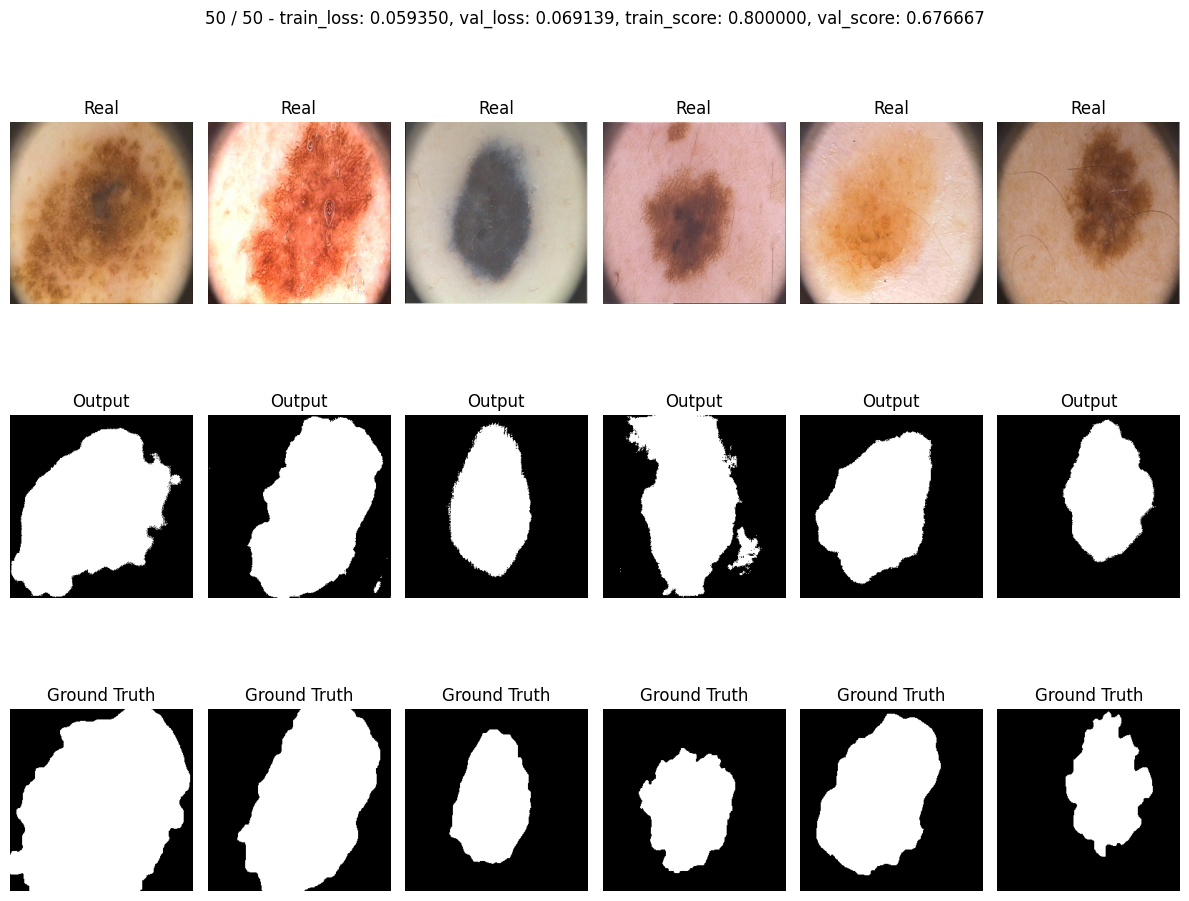

In [65]:
model_unet2_focal = UNet2(32).to(device)

max_epochs = 50
opt = optim.Adam(model_unet2_focal.parameters(), lr=1e-4, amsgrad=True)
unet2_focal = train(model_unet2_focal, opt, focal_loss, max_epochs, data_tr, data_val, agm=True)

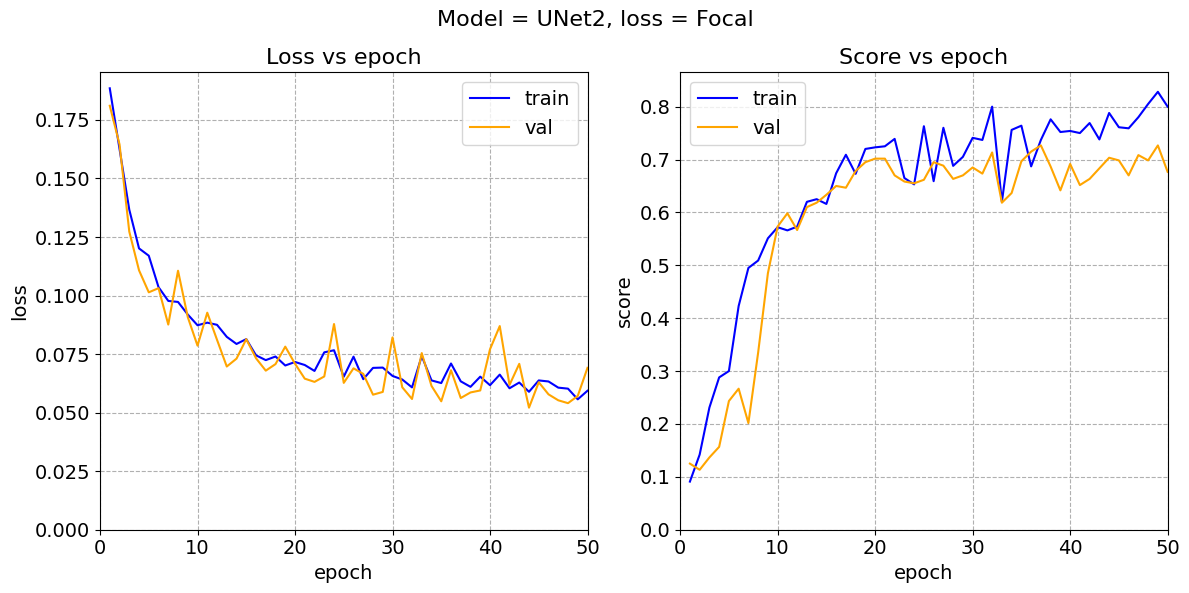

In [66]:
graph(unet2_focal, "UNet2", "Focal")

In [67]:
score_model(model_unet2_focal, iou_pytorch, data_val)

0.703333338101705

### U-Net2 с Lovasz Softmax loss

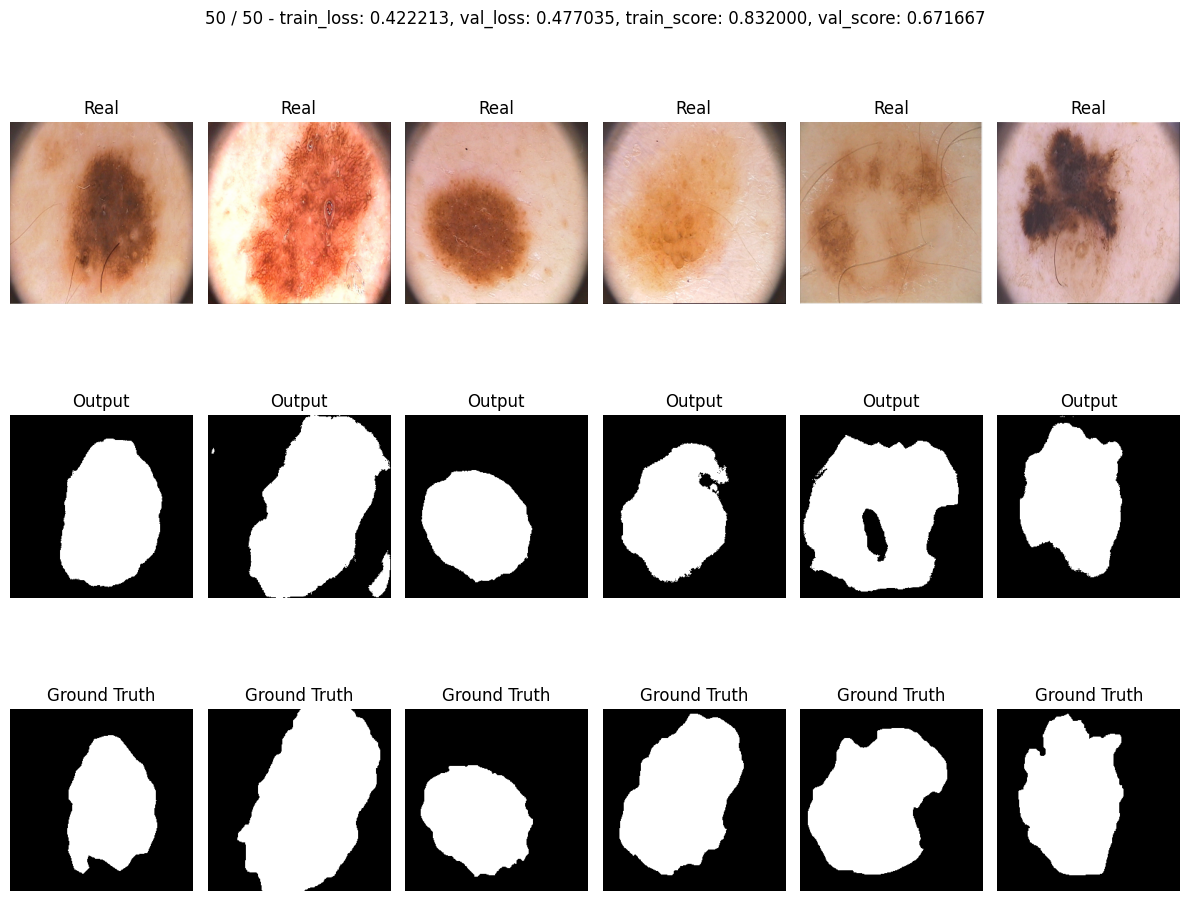

In [70]:
model_unet2_lovasz = UNet2(32).to(device)

max_epochs = 50
opt = optim.Adam(model_unet2_lovasz.parameters(), lr=1e-4, amsgrad=True)
unet2_lovasz = train(model_unet2_lovasz, opt, lovasz_loss, max_epochs, data_tr, data_val, agm=True)

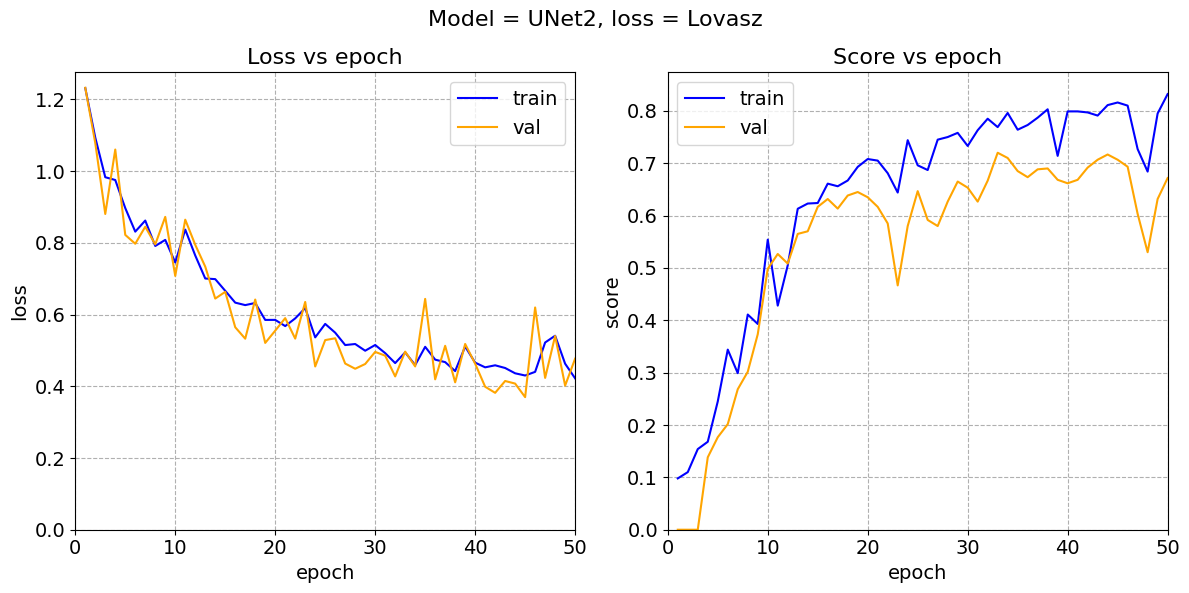

In [71]:
graph(unet2_lovasz, "UNet2", "Lovasz")

In [72]:
score_model(model_unet2_lovasz, iou_pytorch, data_val)

0.7150000135103861

# Итог:

### Анализ score по эпохам в зависимости от модели

In [75]:
x = np.arange(50)+1
fig, ax = plt.subplots(1, 3, figsize=(14, 5), sharey=True)

y1 = segnet_bce["val"]["score"]
y2 = segnet_dice["val"]["score"]
y3 = segnet_focal["val"]["score"]
y4 = segnet_lovasz["val"]["score"]

ax[0].plot(x, y1, label="BCE", color="green")
ax[0].plot(x, y2, label="Dice", color="red")
ax[0].plot(x, y3, label="Focal", color="blue")
ax[0].plot(x, y4, label="Lovasz", color="orange")
ax[0].legend(fontsize=12)
ax[0].grid(linestyle="--")
ax[0].tick_params(labelsize=12)
ax[0].set_ylabel("score", fontsize=13)
ax[0].set_title("SegNet", fontsize=14)
ax[0].set_xlabel("epoch", fontsize=12)
ax[0].set_ylim(0.3, 0.8)


y1 = unet_bce["val"]["score"]
y2 = unet_dice["val"]["score"]
y3 = unet_focal["val"]["score"]
y4 = unet_lovasz["val"]["score"]

ax[1].plot(x, y1, label="BCE", color="green")
ax[1].plot(x, y2, label="Dice", color="red")
ax[1].plot(x, y3, label="Focal", color="blue")
ax[1].plot(x, y4, label="Lovasz", color="orange")
ax[1].legend(fontsize=12)
ax[1].grid(linestyle="--")
ax[1].tick_params(labelsize=12)
ax[1].set_title("UNet", fontsize=14)
ax[1].set_xlabel("epoch", fontsize=12)
ax[1].set_ylim(0.3, 0.8)


y1 = unet2_bce["val"]["score"]
y2 = unet2_dice["val"]["score"]
y3 = unet2_focal["val"]["score"]
y4 = unet2_lovasz["val"]["score"]

ax[2].plot(x, y1, label="BCE", color="green")
ax[2].plot(x, y2, label="Dice", color="red")
ax[2].plot(x, y3, label="Focal", color="blue")
ax[2].plot(x, y4, label="Lovasz", color="orange")
ax[2].legend(fontsize=12)
ax[2].grid(linestyle="--")
ax[2].tick_params(labelsize=12)
ax[2].set_title("UNet2", fontsize=14)
ax[2].set_xlabel("epoch", fontsize=12)
ax[2].set_ylim(0.3, 0.8)

plt.suptitle(f"Score vs epoch (validation dataset)", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

Таким образом, максимальный score по всем моделям распологается на примерно одном уровне - 0.7. Наибольшую стабильность показал Focal loss. Однако, стоит отметить, что для лучшего понимания асимптотик следовало бы обучить модели на большем количестве эпох с lr decay.

### Анализ скора на тестовом датасете

In [76]:
def scores(model):
    val_score = score_model(model, iou_pytorch, data_val)
    test_score = score_model(model, iou_pytorch, data_ts)
    return val_score, test_score

In [77]:
segnet_bce_val_score, segnet_bce_test_score = scores(model_segnet_bce)
segnet_dice_val_score, segnet_dice_test_score = scores(model_segnet_dice)
segnet_focal_val_score, segnet_focal_test_score = scores(model_segnet_focal)
segnet_lovasz_val_score, segnet_lovasz_test_score = scores(model_segnet_lovasz)

unet_bce_val_score, unet_bce_test_score = scores(model_unet_bce)
unet_dice_val_score, unet_dice_test_score = scores(model_unet_dice)
unet_focal_val_score, unet_focal_test_score = scores(model_unet_focal)
unet_lovasz_val_score, unet_lovasz_test_score = scores(model_unet_lovasz)

unet2_bce_val_score, unet2_bce_test_score = scores(model_unet2_bce)
unet2_dice_val_score, unet2_dice_test_score = scores(model_unet2_dice)
unet2_focal_val_score, unet2_focal_test_score = scores(model_unet2_focal)
unet2_lovasz_val_score, unet2_lovasz_test_score = scores(model_unet2_lovasz)

<ipython-input-82-25962e2128f7>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap("viridis", 12).colors


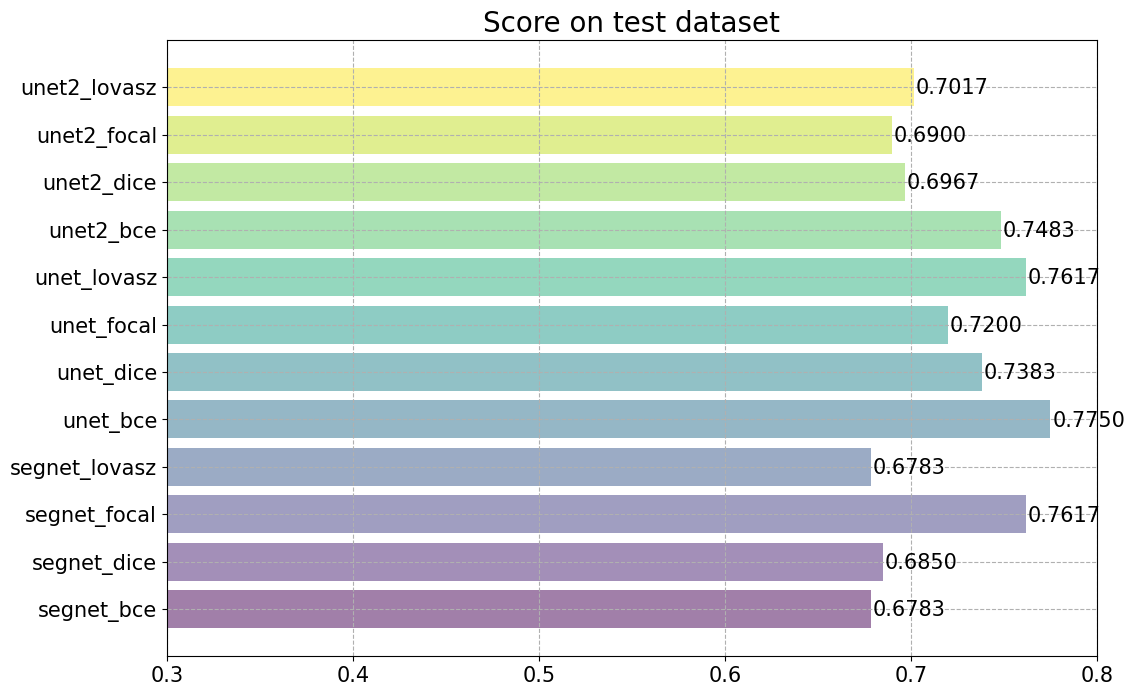

In [82]:
y = [segnet_bce_test_score, segnet_dice_test_score, segnet_focal_test_score, segnet_lovasz_test_score,
     unet_bce_test_score, unet_dice_test_score, unet_focal_test_score, unet_lovasz_test_score,
     unet2_bce_test_score, unet2_dice_test_score, unet2_focal_test_score, unet2_lovasz_test_score]

x = ['segnet_bce', 'segnet_dice', 'segnet_focal', 'segnet_lovasz',
     'unet_bce', 'unet_dice', 'unet_focal', 'unet_lovasz',
     'unet2_bce', 'unet2_dice', 'unet2_focal', 'unet2_lovasz']


fig, ax = plt.subplots(figsize=(12, 8))
colors = cm.get_cmap("viridis", 12).colors
ax.barh(x, y, color=colors, alpha=0.5)
ax.set_xlim(0.3, 0.8)
ax.tick_params(labelsize=15)
for i in range(12):
    ax.text(y[i]+0.001, i - 0.15, f"{y[i]:.4f}", fontsize=15)
    ax.grid(linestyle="--")
ax.set_title("Score on test dataset", fontsize=20)
plt.show()

На тестовом датасете лидером оказалась модель U-Net с лоссом BCE. Можно сделать вывод, что архитектура U-Net в целом показывает лучшее качество пр сравнению с SegNet, во многом благодаря skip-connections. Лучшим лоссом в данном случае оказался BCE.